In [32]:
import numpy as np
import pandas as pd
import csv
import statistics
import matplotlib.pyplot as plt

**READ IN CSVs PRODUCED BY two_photon & edgescore scripts**

In [77]:
root = '../data/exp_627823571_VISp/'
max_dff_ordered=pd.read_csv(root + 'max_dff_subset_ordered.csv') # natural
mean_dff_ordered=pd.read_csv(root + 'mean_dff_subset_ordered.csv') # natural 
ns_stim_exp=pd.read_csv(root +'ns_stim_frame_presentation.csv') # natural 
pref_ori_ordered=pd.read_csv(root +'pref_ori_ordered_subset.csv') # static 
list_of_osi_cells = pd.read_csv(root + 'cell_specimen_id_filtered.csv') # static 
edge_scores=pd.read_csv('../data/edge_scores_normalized_by_sum.csv')


**FIND AVERAGE DFF FOR EACH IMAGE FOR EACH CELL (AVERAGING ACROSS THE 50 REPLICATES OF EACH STIM PRESENTATION)**

In [80]:
# adjust frame numbers by making every instance of 1 -> 117 
list_ns_stim_exp=list(ns_stim_exp.frame)
list_ns_stim_exp_adjusted = [117.0 if value == -1 else value for value in list_ns_stim_exp]


In [81]:
# transpose dff dataframes to prepare to associate with each natural scene frame
max_dff_ordered_t=max_dff_ordered.T
mean_dff_ordered_t=mean_dff_ordered.T

In [82]:
print(max_dff_ordered['cell_specimen_id'])

0      662199605
1      662199626
2      662199683
3      662199697
4      662199710
         ...    
117    662203014
118    662203030
119    662203048
120    662203077
121    662203089
Name: cell_specimen_id, Length: 122, dtype: int64


In [83]:
print(list_of_osi_cells)

    cell_specimen_id_filtered
0                   662200445
1                   662201985
2                   662202121
3                   662201848
4                   662202564
..                        ...
64                  662200841
65                  662201580
66                  662199848
67                  662202289
68                  662200547

[69 rows x 1 columns]


In [84]:
pref_ori_ordered


,cell_specimen_id,pref_ori
0,662199605,90
1,662199626,90
2,662199683,120
3,662199697,0
4,662199710,0
...,...,...
117,662203014,90
118,662203030,60
119,662203048,60
120,662203077,90


In [85]:
pref_ori_lists = {90: [], 120: [], 0: [], 30: [], 60: [], 150: []}
df_pref_ori_ordered = pd.DataFrame(pref_ori_ordered)


for index, row in df_pref_ori_ordered.iterrows():
    cell_specimen_id = row['cell_specimen_id']
    pref_ori = row['pref_ori']
    pref_ori_lists[pref_ori].append(cell_specimen_id)

print(pref_ori_lists)


{90: [662199605, 662199626, 662199727, 662199848, 662199907, 662200053, 662200071, 662200097, 662200146, 662200241, 662200268, 662200347, 662200392, 662200494, 662200841, 662201033, 662201114, 662201262, 662201359, 662201468, 662201555, 662201643, 662201690, 662202375, 662202564, 662202597, 662202673, 662202690, 662202948, 662203014, 662203077], 120: [662199683, 662199835, 662200445, 662200486, 662200560, 662200636, 662200729, 662201175, 662201674, 662201773, 662201791, 662201965, 662201975, 662202121, 662202542, 662203089], 0: [662199697, 662199710, 662200128, 662200162, 662200527, 662200746, 662200759, 662201098, 662201246, 662201299, 662201459, 662201492, 662201594, 662201744, 662201807, 662201917, 662202157, 662202510, 662202612, 662202627, 662202641, 662202654, 662202747, 662202935], 30: [662200029, 662200180, 662200220, 662200515, 662200969, 662201050, 662201087, 662201126, 662201233, 662201254, 662201325, 662201381, 662201406, 662201516, 662201874, 662202175, 662202199, 66220222

In [86]:
mean_dff_ordered_filtered = mean_dff_ordered[mean_dff_ordered['cell_specimen_id'].isin(list_of_osi_cells['cell_specimen_id_filtered'])]
max_dff_ordered_filtered = max_dff_ordered[max_dff_ordered['cell_specimen_id'].isin(list_of_osi_cells['cell_specimen_id_filtered'])]

In [87]:
# replace numbers 0-5949 in ns_stim_frame_presentation with ns_stim_list 
# IMPT: only run this once! to not change list_ns_stim_exp_adjusted again
list_ns_stim_exp_adjusted = ['cell_specimen_id'] + list_ns_stim_exp_adjusted
mean_dff_ordered_filtered.columns = list_ns_stim_exp_adjusted
max_dff_ordered_filtered.columns = list_ns_stim_exp_adjusted


In [88]:
# creating a dictionary that separates mean_dff_ordered_filtered and max_dff_ordered_filtered by preferred orientation
mean_dff_ordered_filtered_with_pref_ori = pd.merge(mean_dff_ordered_filtered, pref_ori_ordered, on='cell_specimen_id')
max_dff_ordered_filtered_with_pref_ori = pd.merge(max_dff_ordered_filtered, pref_ori_ordered, on='cell_specimen_id')

mean_df_dict = {}
max_df_dict = {}
for pref_ori_value in [0, 30, 60, 90, 120, 150]:
    mean_df_dict[pref_ori_value] = mean_dff_ordered_filtered_with_pref_ori[mean_dff_ordered_filtered_with_pref_ori['pref_ori'] == pref_ori_value].drop(columns=['pref_ori'])
    max_df_dict[pref_ori_value] = max_dff_ordered_filtered_with_pref_ori[max_dff_ordered_filtered_with_pref_ori['pref_ori'] == pref_ori_value].drop(columns=['pref_ori'])

In [89]:
# Since each image is repeated 50 times, for each cell I will average the 50 repetitions of each image. 
# This should reduce the number of columns from 5951 image repetitions to 118 images 
for pref_ori_value in [0, 30, 60, 90, 120, 150]:
    mean_df_dict[pref_ori_value] = mean_df_dict[pref_ori_value].groupby(axis=1, level=0).mean()
    max_df_dict[pref_ori_value] = max_df_dict[pref_ori_value].groupby(axis=1, level=0).mean()

In [90]:
# sanity check to check the size 
mean_df_dict[0]

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0,cell_specimen_id
1,0.009454,0.005373,-0.002828,0.003116,-0.008493,0.008884,0.044473,0.015386,0.003584,0.017722,...,0.002807,-0.001065,0.003550,0.007416,0.003985,0.027264,0.004645,0.004043,0.004039,662199710.0
11,0.004739,0.070339,0.030726,0.024908,-0.001084,0.032513,0.022294,0.038491,0.007436,0.056288,...,0.024904,0.003660,0.001027,0.003558,0.013721,0.016156,0.028756,0.024206,0.016602,662200128.0
24,0.013904,0.031686,0.024406,0.007295,0.003767,0.036877,0.004013,0.003049,-0.002763,0.032137,...,0.070592,-0.006828,-0.000344,0.019400,0.038843,0.015374,0.004066,0.002074,0.028205,662200759.0
30,0.004343,-0.001850,0.002329,0.006064,-0.004865,0.013781,0.004687,0.006330,0.005218,0.009123,...,-0.003672,0.004827,0.007934,0.012825,0.002102,0.007616,0.001255,0.015152,0.008320,662201098.0
33,-0.002235,0.018922,0.013353,0.001002,-0.002236,-0.003419,0.024264,0.000472,-0.001527,0.017659,...,0.000699,0.006586,0.005952,0.003617,-0.001589,0.016610,0.000605,-0.000965,-0.004440,662201246.0
37,0.036699,0.005736,0.003640,-0.005659,0.019586,0.019772,0.054258,0.020205,0.011856,0.005329,...,0.074978,-0.002178,0.007373,0.005881,-0.016882,0.012646,0.003953,0.030676,0.012954,662201459.0
38,-0.001434,0.036581,0.017715,0.015636,0.002494,0.073714,0.045229,0.000636,0.011010,0.040749,...,0.050463,0.059228,-0.000456,0.035776,0.005570,0.041569,0.007748,0.001630,0.004060,662201492.0
40,0.006548,0.009619,0.025525,0.000348,0.003733,0.053203,0.024337,0.023131,0.056824,0.061432,...,0.031032,0.010743,0.030373,0.003341,0.020706,0.012665,0.081996,0.013570,0.048966,662201594.0
41,-0.004100,0.005327,0.009300,-0.003702,-0.003136,0.000204,0.006965,0.004596,0.008347,0.011219,...,0.000571,0.000097,0.010363,0.007258,0.002199,0.000897,0.007270,-0.005996,-0.004170,662201744.0
42,-0.001074,0.001192,0.000488,0.001149,-0.010051,0.039341,0.002533,0.007718,0.006422,0.011066,...,-0.003449,0.014310,0.002276,0.025963,0.017862,0.019667,-0.008537,0.007842,0.008036,662201807.0


In [110]:
# print out format of edge scores
edge_scores

,image_id,0,30,60,90,120,150
0,0,0.140268,0.113346,0.117948,0.158095,0.234487,0.235856
1,1,0.111325,0.153892,0.183915,0.229867,0.176943,0.144058
2,2,0.178618,0.139028,0.134122,0.158725,0.197833,0.191674
3,3,0.114039,0.130004,0.161034,0.209393,0.203055,0.182475
4,4,0.099571,0.169813,0.222011,0.233712,0.134635,0.140258
...,...,...,...,...,...,...,...
113,113,0.613158,0.158085,0.066591,0.025282,0.046567,0.090316
114,114,0.025913,0.051173,0.124503,0.603462,0.126572,0.068376
115,115,0.179647,0.207055,0.145380,0.094193,0.165506,0.208220
116,116,0.154026,0.155797,0.151183,0.143921,0.195839,0.199233


In [162]:
for degree in [0, 30, 60, 90, 120, 150]:
    mean_df_dict[degree] = (mean_df_dict[degree]).T

mean_df_dict[30] 



,7,12,18,28,29,32,36,51,52
0.0,7.832703e-03,3.421268e-02,4.519601e-03,2.812082e-05,1.026471e-03,1.464238e-02,7.607626e-03,3.813270e-03,2.413003e-02
1.0,1.593519e-02,1.137377e-02,8.950641e-03,6.084275e-03,1.890178e-03,9.542534e-02,1.140819e-01,-1.685600e-03,1.369147e-01
2.0,1.636862e-02,3.632197e-03,-1.089695e-03,-1.659305e-03,-4.071367e-04,1.167570e-01,7.778034e-02,1.338358e-02,5.374515e-02
3.0,3.772106e-03,5.892945e-02,2.481526e-03,4.313835e-03,2.467772e-04,1.072378e-01,1.050776e-01,7.643377e-03,2.522015e-02
4.0,-4.605573e-03,1.019966e-02,5.161066e-03,1.249040e-03,5.307069e-03,2.635322e-03,-3.265779e-03,-4.029674e-04,5.488748e-02
...,...,...,...,...,...,...,...,...,...
114.0,9.798033e-03,4.797381e-02,5.968081e-03,6.375392e-03,-1.294394e-03,7.490316e-02,2.185066e-02,7.965355e-03,4.094530e-02
115.0,2.364802e-02,1.542781e-02,3.873855e-03,2.007311e-02,-8.867022e-04,7.694043e-02,5.104454e-02,1.574106e-02,1.123629e-02
116.0,-2.889997e-03,5.290378e-03,7.318643e-03,-2.333616e-03,-8.505353e-03,1.297997e-01,2.651929e-02,3.576593e-02,1.285070e-02
117.0,-5.225550e-04,2.735871e-02,1.737832e-02,9.215346e-03,6.066719e-03,7.787074e-02,8.489763e-02,4.722913e-03,1.648756e-02


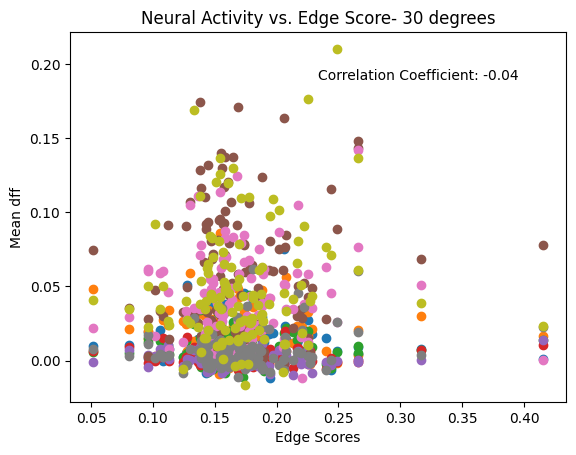

In [167]:
from scipy.stats import pearsonr
# just plotting for cells selective for 30 degree edges

# get one column of edge_scores
edge_score_30 = edge_scores['30']

for column in mean_df_dict[30].columns:
    plt.scatter(edge_score_30, mean_df_dict[30][column][:-1])
plt.xlabel('Edge Scores')  # Replace with your actual x-axis label
plt.ylabel('Mean dff') 
plt.title("Neural Activity vs. Edge Score- 30 degrees")

correlation_coefficient, _ = pearsonr(edge_score_0, mean_df_dict[30][7][:-1])

# Display the correlation coefficient on the plot
plt.text(0.5, 0.9, f'Correlation Coefficient: {correlation_coefficient:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.show()

*Ashley's code*
**SUBSET pref_ori_ordered BY PREFERRED DEGREE**

In [42]:
cell_pref_0=[]
cell_pref_30=[]
cell_pref_60=[]
cell_pref_90=[]
cell_pref_120=[]
cell_pref_150=[]

def subset_pref_ori (list_cell_pref, degree):
    for i in range(len(pref_ori_ordered)):
        if pref_ori_ordered.loc[i]['pref_ori'] == degree:
            list_cell_pref.append(pref_ori_ordered.loc[i]['cell_specimen_id'])

subset_pref_ori(cell_pref_0, 0)
subset_pref_ori(cell_pref_30, 30)
subset_pref_ori(cell_pref_60, 60)
subset_pref_ori(cell_pref_90, 90)
subset_pref_ori(cell_pref_120, 120)

In [28]:
False in max_dff_ordered['cell_specimen_id']==pref_ori_ordered['cell_specimen_id']
# the cell IDs and indexes align, which is why I can do this:

False

**AVERAGE THE DFF ACROSS CELLS WITH A PREFERRED ORIENTATION FOR EACH IMAGE**

In [80]:
def pref_ori_avg_dff(cell_pref, cell_pref_max, cell_pref_mean):
    for i in range(len(cell_pref)):
        cell_index=pref_ori_ordered.index[pref_ori_ordered['cell_specimen_id']==cell_pref[i]][0]
        cell_pref_max.append(avg_max_dff_stim_all[cell_index])
        cell_pref_mean.append(avg_mean_dff_stim_all[cell_index])

def avg_pref_ori(cell_pref_max, cell_pref_mean, mean_cells_max, mean_cells_mean):
    # transpose inputs
    cell_pref_max_t=list(map(list, zip(*cell_pref_max)))
    cell_pref_mean_t=list(map(list, zip(*cell_pref_mean)))
    for i in range(len(cell_pref_max_t)):
        avg_max_activity=statistics.mean(cell_pref_max_t[i])
        avg_mean_activity=statistics.mean(cell_pref_mean_t[i])
        mean_cells_max.append(avg_max_activity)
        mean_cells_mean.append(avg_mean_activity)

In [31]:
# make empty lists
pref_0_avg_max_dff=[] # list of lists: len 1 is number cells, len 2 is number images. SCATTERPLOT
pref_0_avg_mean_dff=[] # same vibe here

mean_cells_0_avg_max=[] # mean activity across cells for each img. averaged: 
mean_cells_0_avg_mean=[] # same vibe here

pref_30_avg_max_dff=[] # list of lists: len 1 is number cells, len 2 is number images
pref_30_avg_mean_dff=[] # same vibe here

mean_cells_30_avg_max=[] # mean activity across cells for each img
mean_cells_30_avg_mean=[] # same vibe here

pref_60_avg_max_dff=[] # list of lists: len 1 is number cells, len 2 is number images
pref_60_avg_mean_dff=[] # same vibe here

mean_cells_60_avg_max=[] # mean activity across cells for each img
mean_cells_60_avg_mean=[] # same vibe here

pref_90_avg_max_dff=[] # list of lists: len 1 is number cells, len 2 is number images
pref_90_avg_mean_dff=[] # same vibe here

mean_cells_90_avg_max=[] # mean activity across cells for each img
mean_cells_90_avg_mean=[] # same vibe here

pref_120_avg_max_dff=[] # list of lists: len 1 is number cells, len 2 is number images
pref_120_avg_mean_dff=[] # same vibe here

mean_cells_120_avg_max=[] # mean activity across cells for each img
mean_cells_120_avg_mean=[] # same vibe here

pref_150_avg_max_dff=[] # list of lists: len 1 is number cells, len 2 is number images
pref_150_avg_mean_dff=[] # same vibe here

mean_cells_150_avg_max=[] # mean activity across cells for each img
mean_cells_150_avg_mean=[] # same vibe here

In [32]:
# now do it

# 0
pref_ori_avg_dff(cell_pref_0, pref_0_avg_max_dff, pref_0_avg_mean_dff)
avg_pref_ori(pref_0_avg_max_dff, pref_0_avg_mean_dff, mean_cells_0_avg_max, mean_cells_0_avg_mean)

# 30
pref_ori_avg_dff(cell_pref_30, pref_30_avg_max_dff, pref_30_avg_mean_dff)
avg_pref_ori(pref_30_avg_max_dff, pref_30_avg_mean_dff, mean_cells_30_avg_max, mean_cells_30_avg_mean)

# 60
pref_ori_avg_dff(cell_pref_60, pref_60_avg_max_dff, pref_60_avg_mean_dff)
avg_pref_ori(pref_60_avg_max_dff, pref_60_avg_mean_dff, mean_cells_60_avg_max, mean_cells_60_avg_mean)

# 90
pref_ori_avg_dff(cell_pref_90, pref_90_avg_max_dff, pref_90_avg_mean_dff)
avg_pref_ori(pref_90_avg_max_dff, pref_90_avg_mean_dff, mean_cells_90_avg_max, mean_cells_90_avg_mean)

# 120
pref_ori_avg_dff(cell_pref_120, pref_120_avg_max_dff, pref_120_avg_mean_dff)
avg_pref_ori(pref_120_avg_max_dff, pref_120_avg_mean_dff, mean_cells_120_avg_max, mean_cells_120_avg_mean)

# 150
pref_ori_avg_dff(cell_pref_150, pref_150_avg_max_dff, pref_150_avg_mean_dff)
avg_pref_ori(pref_150_avg_max_dff, pref_150_avg_mean_dff, mean_cells_150_avg_max, mean_cells_150_avg_mean)

IndexError: list index out of range

In [14]:
# ok so now we have: mean neural activity for each image type subsetted by cell preferred orientation
# orientation in this case I centered around 0, 30, 60, 90, 120, 150, +/- 15 degrees
# next step, make a dataframe where we have these activity values for each preferred orientation and each edge score: should be easy

In [15]:
activity_w_edge_scores=edge_scores.copy(True)

activity_w_edge_scores['max_dff_0']=mean_cells_0_avg_max
activity_w_edge_scores['mean_dff_0']=mean_cells_0_avg_mean

activity_w_edge_scores['max_dff_30']=mean_cells_30_avg_max
activity_w_edge_scores['mean_dff_30']=mean_cells_30_avg_mean

# activity_w_edge_scores['max_dff_60']=mean_cells_60_avg_max
# activity_w_edge_scores['mean_dff_60']=mean_cells_60_avg_mean

activity_w_edge_scores['max_dff_90']=mean_cells_90_avg_max
activity_w_edge_scores['mean_dff_90']=mean_cells_90_avg_mean

activity_w_edge_scores['max_dff_120']=mean_cells_120_avg_max
activity_w_edge_scores['mean_dff_120']=mean_cells_120_avg_mean

# activity_w_edge_scores['max_dff_150']=mean_cells_150_avg_max
# activity_w_edge_scores['mean_dff_150']=mean_cells_150_avg_mean



In [16]:
activity_edge_30=list(zip(list(activity_w_edge_scores['30']), list(activity_w_edge_scores['max_dff_30'])))
activity_edge_30.sort(key=lambda x: x[0])

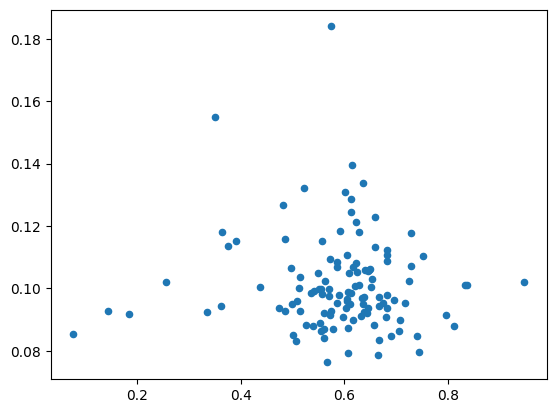

In [17]:
edge_score_30, activity_30 =list(zip(*activity_edge_30))

plt.scatter(edge_score_30, activity_30, marker="o", s=20)

In [18]:
activity_edge_90=list(zip(list(activity_w_edge_scores['90']), list(activity_w_edge_scores['max_dff_90'])))
activity_edge_90.sort(key=lambda x: x[0])

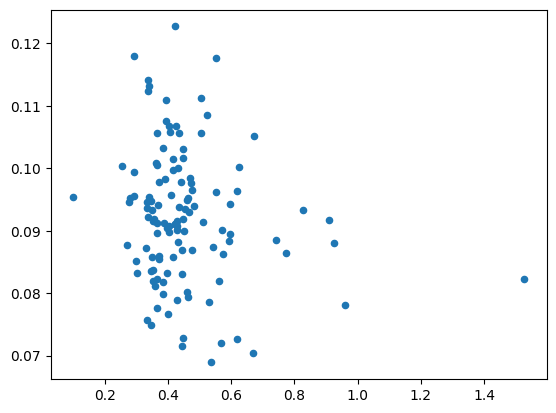

In [19]:
edge_score_90, activity_90 =list(zip(*activity_edge_90))

plt.scatter(edge_score_90, activity_90, marker="o", s=20)

In [20]:
activity_edge_120=list(zip(list(activity_w_edge_scores['120']), list(activity_w_edge_scores['max_dff_120'])))
activity_edge_120.sort(key=lambda x: x[0])

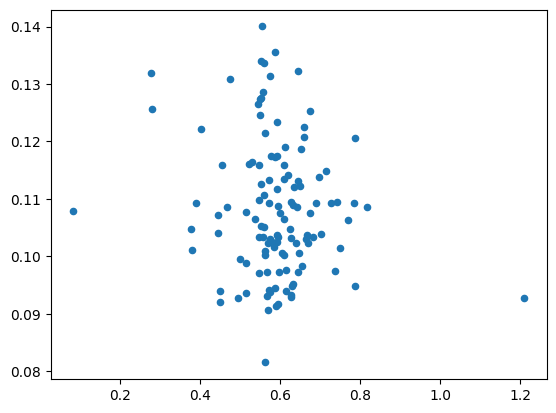

In [21]:
edge_score_120, activity_120 =list(zip(*activity_edge_120))

plt.scatter(edge_score_120, activity_120, marker="o", s=20)